In [77]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

In [50]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

In [51]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [52]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [53]:
train_data.info()
print("-"*100)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [58]:
label_encoder = LabelEncoder()

categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for col in categorical_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [59]:
X_train = train_data.drop(['id', 'loan_status'], axis=1)
y_train = train_data['loan_status']
X_test = test_data.drop(['id'], axis=1)

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression

In [61]:
model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [62]:
test_data['loan_status'] = model.predict_proba(X_test_scaled)[:, 1]
test_data['loan_status'] = test_data['loan_status'].astype(float)
submission = test_data[['id', 'loan_status']]

In [79]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-Validation AUC Scores: {cv_scores}')
print(f'Average AUC Score: {cv_scores.mean()}')

Cross-Validation AUC Scores: [0.87855306 0.87779949 0.88324228 0.88292327 0.88514156]
Average AUC Score: 0.8815319316630681


In [63]:
submission

,id,loan_status
0,58645,0.995642
1,58646,0.157548
2,58647,0.914638
3,58648,0.205670
4,58649,0.487420
...,...,...
39093,97738,0.204438
39094,97739,0.091288
39095,97740,0.167143
39096,97741,0.953164


In [76]:
submission.to_csv('lr_pred.csv', index=False)
print(f'file saved @ {os.listdir("/kaggle/working/")}')

file saved @ ['.virtual_documents', 'lr_pred.csv']


XGBoost

In [80]:
train_data['debt_to_income'] = train_data['loan_amnt'] / train_data['person_income']
test_data['debt_to_income'] = test_data['loan_amnt'] / test_data['person_income']

In [81]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat = encoder.fit_transform(train_data[categorical_cols])
X_test_cat = encoder.transform(test_data[categorical_cols])

In [82]:
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'debt_to_income']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_data[numerical_cols])
X_test_num = scaler.transform(test_data[numerical_cols])

In [83]:
X_train = np.hstack((X_train_num, X_train_cat))
X_test = np.hstack((X_test_num, X_test_cat))
y_train = train_data['loan_status']

In [84]:
# Objective Function for Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    }
    
    model = xgb.XGBClassifier(**param, random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    return auc

In [85]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2024-10-12 06:58:41,536] A new study created in memory with name: no-name-8902ff49-a6d0-4db5-a4a1-eba82a64151f
[I 2024-10-12 06:58:56,123] Trial 0 finished with value: 0.9529391797972799 and parameters: {'learning_rate': 0.11861663446573512, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676, 'n_estimators': 641}. Best is trial 0 with value: 0.9529391797972799.
[I 2024-10-12 06:59:03,753] Trial 1 finished with value: 0.9559727309472912 and parameters: {'learning_rate': 0.21534104756085318, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'reg_alpha': 0.9170225492671691, 'reg_lambda': 1.5212112147976886, 'n_estimators': 572}. Best is trial 1 with value: 0.9559727309472912.
[I 2024-10-12 06:59:09,088] Trial 2 finished with value: 0.95411984

In [86]:
print("Best AUC: ", study.best_value)
print("Best Params: ", study.best_params)

Best AUC:  0.9565162904135063
Best Params:  {'learning_rate': 0.13533012832109606, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8389125038682415, 'colsample_bytree': 0.568532653446305, 'gamma': 0.8386955682585895, 'reg_alpha': 1.2973842753996165, 'reg_lambda': 4.1795151897382885, 'n_estimators': 513}


In [87]:
# train final Model with Best Parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.568532653446305, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.8386955682585895,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13533012832109606,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=513, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [88]:
# Cross-Validation AUC
cv_scores = cross_val_score(final_model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
print(f'Cross-Validation AUC Scores: {cv_scores}')
print(f'Average AUC Score: {cv_scores.mean()}')
test_data['loan_status'] = final_model.predict_proba(X_test)[:, 1].round(6)

print(f'Final Cross-Validation AUC Scores: {final_auc_scores}')
print(f'Final Average AUC Score: {final_auc_scores.mean()}')

Cross-Validation AUC Scores: [0.95025026 0.9630576  0.95316834 0.95812297 0.95798228]
Average AUC Score: 0.9565162904135063
Final Cross-Validation AUC Scores: [0.94307112 0.95757117 0.94777478 0.95407872 0.95285492]
Final Average AUC Score: 0.9510701412564077


In [89]:
classifier = final_pipeline.named_steps['classifier']
preprocessed_data = preprocessor.fit_transform(train_data.drop(['id', 'loan_status'], axis=1))
feature_names_num = numerical_cols
feature_names_cat = final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

In [90]:
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': classifier.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top 20 Feature Importances:")
print(feature_importances.head(20))

Top 20 Feature Importances:
                    feature  importance
21             loan_grade_3    0.211614
11  person_home_ownership_3    0.203478
10  person_home_ownership_2    0.089801
22             loan_grade_4    0.075395
12            loan_intent_0    0.049953
5       loan_percent_income    0.043264
15            loan_intent_3    0.036372
18             loan_grade_0    0.031209
14            loan_intent_2    0.030783
8   person_home_ownership_0    0.028801
7            debt_to_income    0.026847
23             loan_grade_5    0.024161
4             loan_int_rate    0.018104
2         person_emp_length    0.015911
1             person_income    0.015714
19             loan_grade_1    0.014508
17            loan_intent_5    0.014314
20             loan_grade_2    0.014252
13            loan_intent_1    0.011349
16            loan_intent_4    0.009769


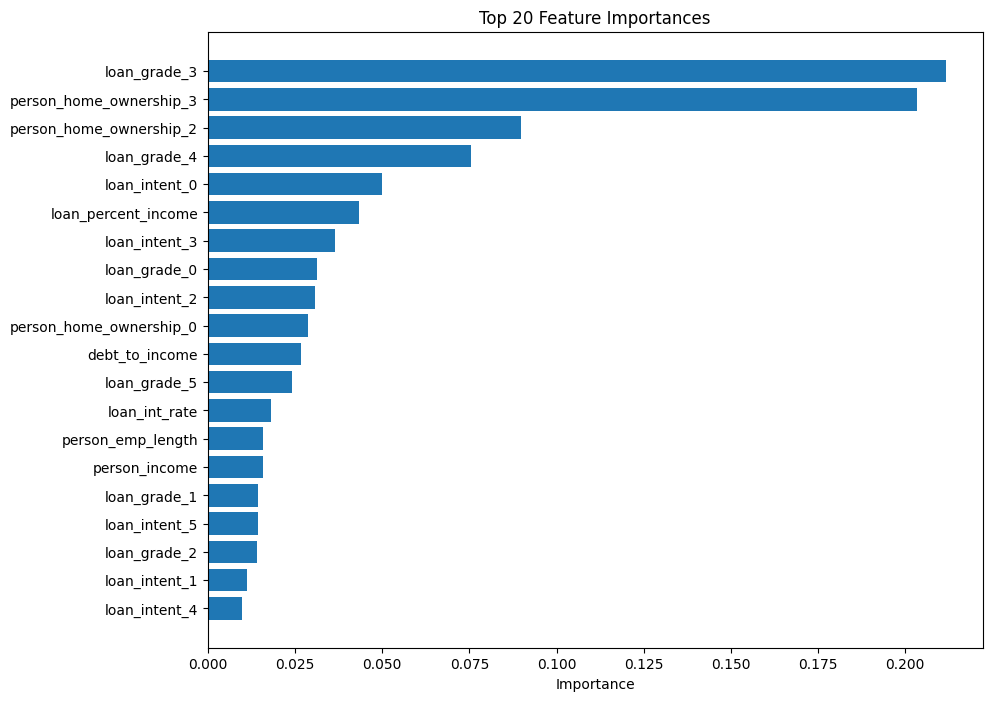

In [91]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'].head(20)[::-1], feature_importances['importance'].head(20)[::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [92]:
test_predictions = final_pipeline.predict_proba(test_data.drop(['id'], axis=1))[:, 1].round(6)
test_data['loan_status'] = test_predictions
submission = test_data[['id', 'loan_status']]
submission

,id,loan_status
0,58645,0.980866
1,58646,0.003178
2,58647,0.208015
3,58648,0.001829
4,58649,0.009979
...,...,...
39093,97738,0.007883
39094,97739,0.001008
39095,97740,0.002334
39096,97741,0.060220


In [93]:
submission.to_csv('xgb_pred.csv', index=False)
print(f'file saved @ {os.listdir("/kaggle/working/")}')

file saved @ ['.virtual_documents', 'xgb_pred.csv', 'lr_pred.csv']


In [94]:
print('END')

END
